In [1]:
!pip3 install cython
!pip3 install tensornets

In [2]:
!wget -O 'content.jpg' https://cdn-images-1.medium.com/max/1600/1*6-xk0GE4Df5cWeu7ewY9Lg.jpeg
!wget -O 'style.jpg' https://c1.staticflickr.com/3/2359/2093162230_044fd74cd8.jpg

--2018-11-26 19:48:34--  https://cdn-images-1.medium.com/max/1600/1*6-xk0GE4Df5cWeu7ewY9Lg.jpeg
Resolving cdn-images-1.medium.com (cdn-images-1.medium.com)... 104.16.118.145, 104.16.119.145, 104.16.117.145, ...
Connecting to cdn-images-1.medium.com (cdn-images-1.medium.com)|104.16.118.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218974 (214K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 213.84K  --.-KB/s    in 0.02s   

2018-11-26 19:48:34 (13.0 MB/s) - ‘content.jpg’ saved [218974/218974]

--2018-11-26 19:48:36--  https://c1.staticflickr.com/3/2359/2093162230_044fd74cd8.jpg
Resolving c1.staticflickr.com (c1.staticflickr.com)... 87.248.114.11, 87.248.114.12, 87.248.116.12, ...
Connecting to c1.staticflickr.com (c1.staticflickr.com)|87.248.114.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74078 (72K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>]  

In [0]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensornets as nets
import IPython.display
from tensorflow.python.keras.preprocessing import image as kp_image

In [0]:
def load_img(path):
  input_size = (224, 224)
  img = Image.open(path)
  img = img.resize(input_size, Image.ANTIALIAS)
  img = np.array(img)[...,:3]
  img = img.astype('float32')
  
  return img

def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img[:, :, 0] -= 103.939
  img[:, :, 1] -= 116.779
  img[:, :, 2] -= 123.68
  img = img[:, :, ::-1]
  
  img = np.expand_dims(img, axis=0)
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
    
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
content_path = 'content.jpg'
style_path = 'style.jpg'

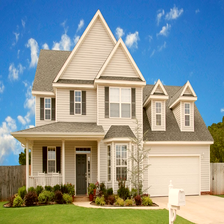

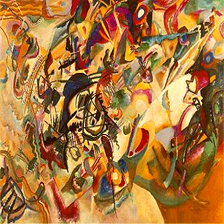

In [6]:
content_img = load_and_process_img(content_path)
style_img = load_and_process_img(style_path)

IPython.display.display_png(Image.fromarray(deprocess_img(content_img)))
IPython.display.display_png(Image.fromarray(deprocess_img(style_img)))

In [0]:
img_var = tf.Variable(content_img, dtype=tf.float32)
model = nets.VGG19(img_var, is_training=False)

In [0]:
layers = [
    'vgg19/conv5/2/Relu',
    'vgg19/conv1/1/Relu',
    'vgg19/conv2/1/Relu',
    'vgg19/conv3/1/Relu',
    'vgg19/conv4/1/Relu',
    'vgg19/conv5/1/Relu'
]

In [0]:
def get_layer(sess, name):
  return sess.graph.get_tensor_by_name(name + ':0')

In [0]:
def get_gram_matrix(x):
  (_, h, w, c) = x.shape
  M = h*w
  N = c
  a = tf.reshape(x, (M, N))
  return tf.matmul(tf.transpose(a), a)/tf.cast((M*M), tf.float32)

def get_style_layers(sess, names):
  layers = []
  for name in names:
    layers.append(get_gram_matrix(get_layer(sess, name)))
  return layers

In [0]:
def get_content_loss(base_c_features, x_c_features):
  _, h, w, c = x_c_features.shape
  N = h*w*c
  return tf.reduce_sum(tf.square(base_c_features - x_c_features))/tf.cast((4*N*N), tf.float32)

In [0]:
def get_style_loss(G, X):
  s_loss_layers = []
  for i in range(len(X)):
    
    n = X[i].shape[0]
    s_loss_layers.append(tf.reduce_sum(tf.square(G[i]-X[i]))/tf.cast((4*(n*n)), tf.float32))
   
  return s_loss_layers

In [0]:
def get_total_loss(sess, alpha, beta, img, content_loss_layer, style_loss_layers):
  style_losses = style_loss_layers[0] + style_loss_layers[1] + style_loss_layers[2] + style_loss_layers[3] + style_loss_layers[4]
  total_losses = alpha*content_loss_layer + (beta/len(style_loss_layers))*(tf.reduce_sum(style_losses))
  
  return [total_losses, alpha*content_loss_layer, (beta/len(style_loss_layers))*style_losses]

In [0]:
with tf.Session() as sess:
  
  sess.run(model.pretrained())
  
  sess.run(img_var.initializer)
  content_layer = get_layer(sess, layers[0])
  style_layers = get_style_layers(sess, layers[1:])
  
  
  img_var.load(content_img, sess)
  content_features = sess.run(content_layer)
  
  
  img_var.load(style_img, sess)
  style_features = [sess.run(l) for l in style_layers]
  
  alpha = 1e3
  beta = 1e-2
  
  style_loss_layers = get_style_loss(style_features, style_layers)
  content_loss_layer = get_content_loss(content_features, content_layer)
  
  
  losses = get_total_loss(sess, alpha, beta, img_var, content_loss_layer, style_loss_layers)
  
  total_loss = losses[0]
  content_loss = losses[1]
  style_loss = losses[2]
  
  opt = tf.train.AdamOptimizer(learning_rate=10.0)
  minimizer = opt.minimize(total_loss, var_list=[img_var])

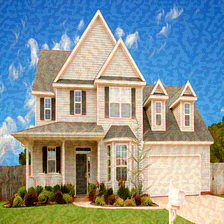

Total loss: 654.1417846679688
Content Loss: 151.00814819335938
Style Loss: 380.7276306152344


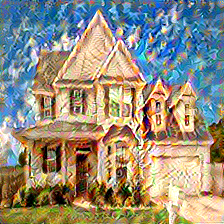

Total loss: 33.1309814453125
Content Loss: 18.665090560913086
Style Loss: 14.555025100708008


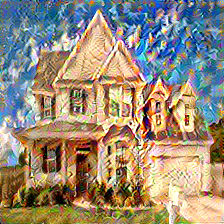

Total loss: 27.15355682373047
Content Loss: 15.033162117004395
Style Loss: 12.145379066467285


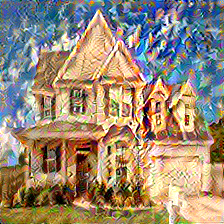

Total loss: 27.550352096557617
Content Loss: 14.689630508422852
Style Loss: 11.46335220336914


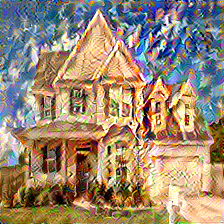

Total loss: 24.422746658325195
Content Loss: 13.81767463684082
Style Loss: 10.557666778564453


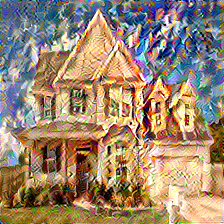

Total loss: 23.330554962158203
Content Loss: 12.734966278076172
Style Loss: 10.62151050567627


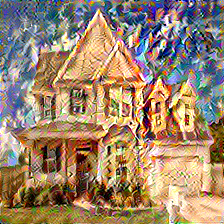

Total loss: 23.195621490478516
Content Loss: 13.147148132324219
Style Loss: 10.57913875579834


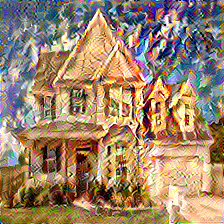

Total loss: 22.496383666992188
Content Loss: 12.490021705627441
Style Loss: 10.017454147338867


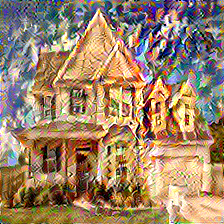

Total loss: 22.043415069580078
Content Loss: 11.964107513427734
Style Loss: 10.090398788452148


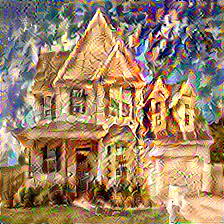

Total loss: 21.622528076171875
Content Loss: 11.718830108642578
Style Loss: 9.99548625946045


In [15]:
with tf.Session() as sess:

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means
  sess.run(model.pretrained())
  sess.run(img_var.initializer)
  
  img_var.load(content_img, sess)
  
  sess.run(tf.variables_initializer(opt.variables()))
  
  
  for i in range(1000):
    _, loss_value = sess.run((minimizer, total_loss))
    
    if i == 0:
      best_score = loss_value
    elif loss_value < best_score:
      best_score = loss_value
      best_img = sess.run(img_var)
    
    clipped = tf.clip_by_value(img_var, min_vals, max_vals)
    img_var.load(sess.run(img_var), sess)
    if i%100 == 0:
      IPython.display.display_png(Image.fromarray(deprocess_img(sess.run(img_var))))
      print(f'Total loss: {loss_value}')
      print(f'Content Loss: {sess.run(content_loss)}')
      print(f'Style Loss: {sess.run(style_loss)}')
  
    

In [0]:
out_img = Image.fromarray(deprocess_img(best_img))
out_img.save('output_image.jpg')
# from google.colab import files
# files.download('output_image.jpg')